<a href="https://colab.research.google.com/github/diegoramfin/ML-Based-Signal-Generator/blob/main/ML_Based_Signal_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML-Based Signal Generator

"I don't assume anything, I'll let ML figure out what alpha is."

This project's approach is vastly different to the Alpha Factor Library as it assumes that the alpha indicators which work are unknown. The philosophy is to feed it raw data and let the model discover what's predictive.

Goal:
Preidct the chosen day return direction (magnitude) of a stock using technical indicators, rolling statistics, and price freatures, trade based on ML model's output.

Project is still a WIP.
Educational purposes only.

In [90]:
#Intial Data Grab

import yfinance as yf

tickers = ['AAPL', 'MSFT', 'GOOGL']
df = yf.download(tickers, start="2015-01-01", end="2024-12-31", group_by='ticker')


/tmp/ipython-input-90-2755159290.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start="2015-01-01", end="2024-12-31", group_by='ticker')
[*********************100%***********************]  3 of 3 completed


In [91]:
!pip install ta
from ta import add_all_ta_features
import pandas as pd

df_indicators = []
for ticker in tickers:
    df_price = df[ticker].dropna()
    df_enriched = add_all_ta_features(
        df_price, open="Open", high="High", low="Low", close="Close", volume="Volume"
    )
    df_enriched['ticker'] = ticker
    df_indicators.append(df_enriched)

features = pd.concat(df_indicators)

features.head()

/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Price,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,ticker
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,24.746224,24.757332,23.848704,24.288578,212818400,-6.764250e+06,212818400,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,AAPL
2015-01-05,24.057535,24.137513,23.417720,23.604332,257142000,-1.305739e+08,-44323600,NaN,NaN,-0.147071,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.817152,-2.857595,-2.817152,AAPL
2015-01-06,23.668754,23.866475,23.244431,23.606550,263188400,-8.733518e+07,218864800,NaN,NaN,-0.052508,...,NaN,NaN,NaN,NaN,NaN,NaN,0.009398,0.009397,-2.808019,AAPL
2015-01-07,23.815385,24.037543,23.704305,23.937572,160423600,-2.316508e+07,379288400,NaN,NaN,0.065531,...,NaN,NaN,NaN,NaN,NaN,NaN,1.402248,1.392507,-1.445147,AAPL
2015-01-08,24.266365,24.915067,24.148620,24.857306,237458000,1.785019e+08,616746400,NaN,NaN,0.213326,...,NaN,NaN,NaN,NaN,NaN,NaN,3.842215,3.770240,2.341543,AAPL


In [92]:
# Add custom features
features['return_5d'] = features['Close'].pct_change(5)
features['volatility_10d'] = features['Close'].pct_change().rolling(10).std()
features['vol_5d'] = features['Close'].pct_change().rolling(5).std()
features['sma_10'] = features['Close'].rolling(10).mean()
features['price_vs_sma_10'] = features['Close'] / features['sma_10'] - 1
features['momentum_5d'] = features['Close'] / features['Close'].shift(5) - 1
features['volume_z'] = (features['Volume'] - features['Volume'].rolling(20).mean()) / features['Volume'].rolling(20).std()
features['vol_20d'] = features['Close'].pct_change().rolling(20).std()
features['regime'] = pd.qcut(features['vol_20d'], 3, labels=['low_vol', 'mid_vol', 'high_vol'])
features['price_vs_bb'] = (features['Close'] - features['volatility_bbm']) / (features['volatility_bbh'] - features['volatility_bbl'])
features['ichimoku_diff'] = features['trend_ichimoku_a'] - features['trend_ichimoku_b']
features["mean_reversion"] = features["Close"] - features["Close"].rolling(20).mean()


In [95]:
import pandas as pd
import numpy as np

all_X = []
all_y = []

for ticker in tickers:
    df_stock = features[features['ticker'] == ticker].copy()
    df_stock = df_stock.sort_index()
    df_stock['future_ret'] = df_stock['Close'].shift(-25) / df_stock['Close'] - 1
    df_stock = df_stock.iloc[:-25]
    split_idx = int(len(df_stock) * 0.8)
    df_train = df_stock.iloc[:split_idx].copy()
    df_test = df_stock.iloc[split_idx:].copy()
    q1, q2 = df_train['future_ret'].quantile([0.33, 0.67])
    df_train['target'] = pd.cut(df_train['future_ret'], bins=[-np.inf, q1, q2, np.inf], labels=[0,1,2])
    df_test['target'] = pd.cut(df_test['future_ret'], bins=[-np.inf, q1, q2, np.inf], labels=[0,1,2])
    df_train['target_binary'] = (df_train['target'] == 2).astype(int)
    df_test['target_binary'] = (df_test['target'] == 2).astype(int)
    drop_cols = ['target', 'target_binary', 'future_ret', 'Close', 'Open', 'High', 'Low', 'Volume', 'ticker']
    X_train = df_train.drop(columns=drop_cols, errors='ignore')
    X_test = df_test.drop(columns=drop_cols, errors='ignore')
    X_train = pd.get_dummies(X_train, columns=['regime'], dummy_na=False)
    X_test = pd.get_dummies(X_test, columns=['regime'], dummy_na=False)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
    y_train = df_train['target_binary']
    y_test = df_test['target_binary']
    all_X.append(X_train)
    all_y.append(y_train)


X = pd.concat(all_X).astype(np.float32)
y = pd.concat(all_y)
print("Train:", df_train['target'].value_counts())
print("Test:", df_test['target'].value_counts())

Train: target
1    676
0    658
2    658
Name: count, dtype: int64
Test: target
2    217
1    155
0    126
Name: count, dtype: int64


In [96]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

# Step 1: Split with no shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# Step 2: Drop missing labels before any fitting
train_mask = y_train.notna().values
test_mask = y_test.notna().values

X_train_filtered = X_train[train_mask]
y_train_filtered = y_train[train_mask]

X_test_filtered = X_test[test_mask]
y_test_filtered = y_test[test_mask]

# Step 3: Impute
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_filtered)
X_test_imputed = imputer.transform(X_test_filtered)

# Step 4: Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Final sets
X_train_clean = X_train_scaled
y_train_clean = y_train_filtered

X_test_clean = X_test_scaled
y_test_clean = y_test_filtered


In [97]:
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

# Use the same cleaned training set
tree_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)
tree_model.fit(X_train_clean, y_train_clean)

selector_tree = SelectFromModel(tree_model, prefit=True, threshold="median")
X_train_tree = selector_tree.transform(X_train_clean)
X_test_tree = selector_tree.transform(X_test_clean)

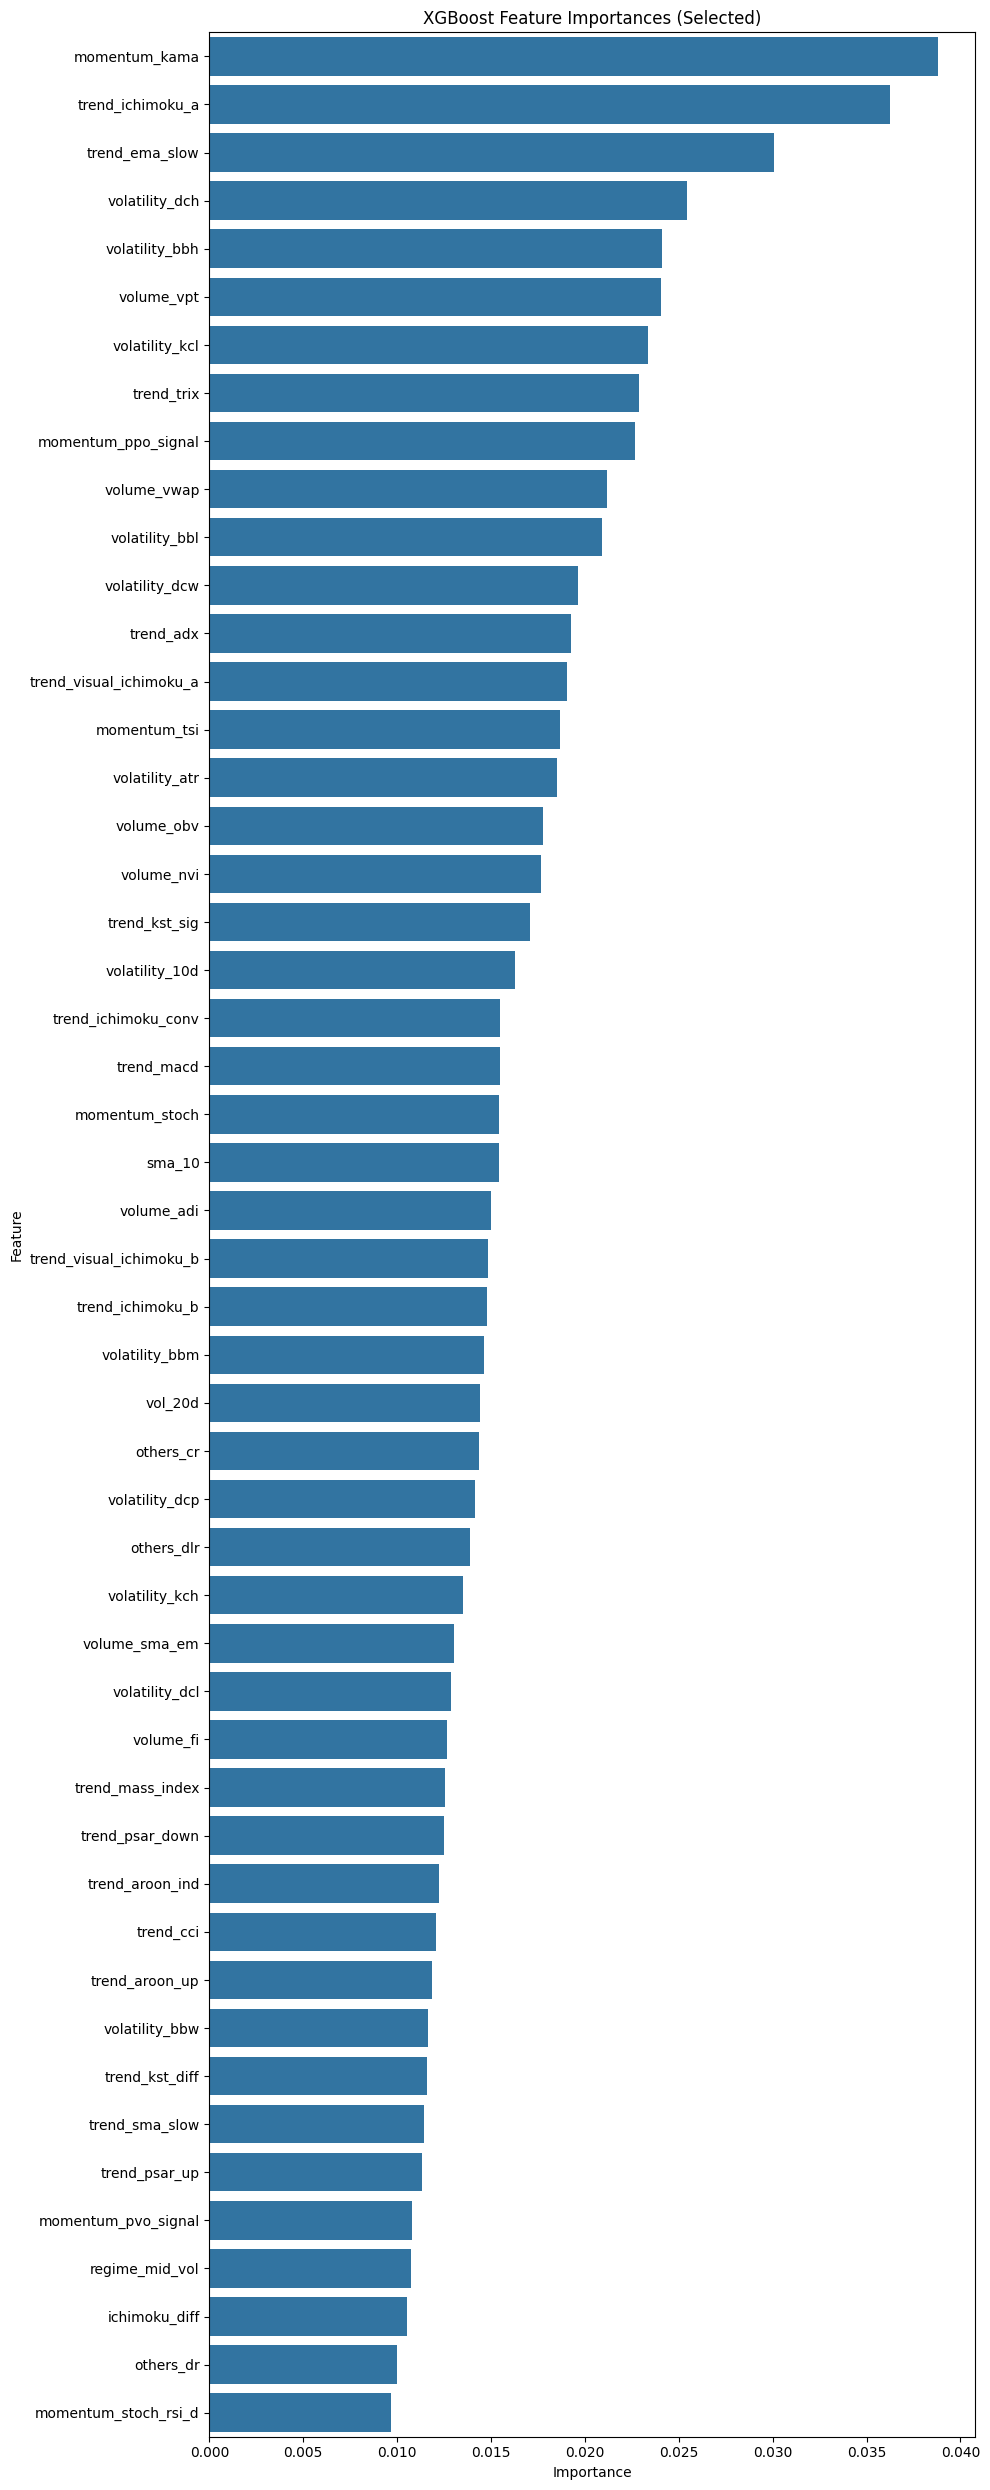

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = X.columns if hasattr(X, 'columns') else [f'feature_{i}' for i in range(X.shape[1])]
importances = tree_model.feature_importances_
mask = selector_tree.get_support()
selected_names = np.array(feature_names)[mask]

selected_importances = importances[mask]

plt.figure(figsize=(10, len(selected_names) * 0.5))
sorted_idx = np.argsort(-selected_importances)
sns.barplot(
    x=selected_importances[sorted_idx],
    y=selected_names[sorted_idx]
)
plt.title("XGBoost Feature Importances (Selected)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [117]:
#Last Data Prep

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegressionCV

selector_mi = SelectKBest(score_func=mutual_info_classif, k=35)
X_train_selected = selector_mi.fit_transform(X_train_tree, y_train_clean)
X_test_selected = selector_mi.transform(X_test_tree)

In [118]:
#Model 1 Logistic RegressionCV deployment
model = LogisticRegressionCV(
    Cs=[10],
    cv=5,
    multi_class='multinomial',
    solver='saga',
    penalty='l1',
    max_iter=6000,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_selected, y_train_clean)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1898: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegressionCV(Cs=[10], class_weight='balanced', cv=5, max_iter=6000,
                     multi_class='multinomial', penalty='l1', random_state=42,
                     solver='saga')

In [119]:
#Model 2 Logistic Rgeression with Elasticnet deloyment

from sklearn.linear_model import LogisticRegression

model2 = LogisticRegression(penalty="elasticnet", solver='saga', l1_ratio=0.5, C=0.1, max_iter=3000, class_weight='balanced')

model2.fit(X_train_selected, y_train_clean)

LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.5, max_iter=3000,
                   penalty='elasticnet', solver='saga')

In [120]:
#Model 1
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# Predict probabilities for positive class (class 1) on your test set
probs = model.predict_proba(X_test_selected)[:, 1]

# Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test_clean, probs)

# Calculate F1 scores for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # avoid div by zero

# Find index of the best F1 score
best_idx = np.argmax(f1_scores)

best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1 score: {best_f1:.3f}")

# Generate predictions using the best threshold
adjusted_preds = (probs >= best_threshold).astype(int)

# Evaluate final classification
from sklearn.metrics import classification_report
print(classification_report(y_test_clean, adjusted_preds))


Best threshold: 0.114
Best F1 score: 0.540
              precision    recall  f1-score   support

           0       0.84      0.21      0.33       978
           1       0.38      0.92      0.54       516

    accuracy                           0.46      1494
   macro avg       0.61      0.57      0.44      1494
weighted avg       0.68      0.46      0.41      1494



In [121]:
#Model 2

from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# Predict probabilities for positive class (class 1) on your test set
probs = model2.predict_proba(X_test_selected)[:, 1]

# Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test_clean, probs)

# Calculate F1 scores for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # avoid div by zero

# Find index of the best F1 score
best_idx = np.argmax(f1_scores)

best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1 score: {best_f1:.3f}")

# Generate predictions using the best threshold
adjusted_preds = (probs >= best_threshold).astype(int)

# Evaluate final classification
from sklearn.metrics import classification_report
print(classification_report(y_test_clean, adjusted_preds))


Best threshold: 0.195
Best F1 score: 0.536
              precision    recall  f1-score   support

           0       0.81      0.24      0.37       978
           1       0.38      0.89      0.54       516

    accuracy                           0.47      1494
   macro avg       0.60      0.57      0.45      1494
weighted avg       0.66      0.47      0.43      1494



In [125]:
#Model 1, LogisticRegressionCV

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

y_pred = model.predict(X_test_selected)
y_prob = model.predict_proba(X_test_selected)

print("Classification Report:\n", classification_report(y_test_clean, y_pred))
print("Model converged in:", model.n_iter_.max(), "iterations")

# Optional AUC for each class
from sklearn.metrics import roc_auc_score
y_test_onehot = pd.get_dummies(y_test_clean)
auc = roc_auc_score(y_test_onehot, y_prob, average='macro')
print("Multiclass AUC:", round(auc, 4))

Classification Report:
               precision    recall  f1-score   support

           0       0.66      1.00      0.80       978
           1       1.00      0.03      0.07       516

    accuracy                           0.67      1494
   macro avg       0.83      0.52      0.43      1494
weighted avg       0.78      0.67      0.55      1494

Model converged in: 5187 iterations
Multiclass AUC: 0.6434


In [126]:
#Model 2, Logistic Regression with Elasticnet

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

y_pred = model2.predict(X_test_selected)
y_prob = model2.predict_proba(X_test_selected)

print("Classification Report:\n", classification_report(y_test_clean, y_pred))
print("Model converged in:", model2.n_iter_.max(), "iterations")

# Optional AUC for each class
from sklearn.metrics import roc_auc_score
y_test_onehot = pd.get_dummies(y_test_clean)
auc = roc_auc_score(y_test_onehot, y_prob, average='macro')
print("Multiclass AUC:", round(auc, 4))

Classification Report:
               precision    recall  f1-score   support

           0       0.66      1.00      0.80       978
           1       1.00      0.03      0.05       516

    accuracy                           0.66      1494
   macro avg       0.83      0.51      0.42      1494
weighted avg       0.78      0.66      0.54      1494

Model converged in: 103 iterations
Multiclass AUC: 0.6432


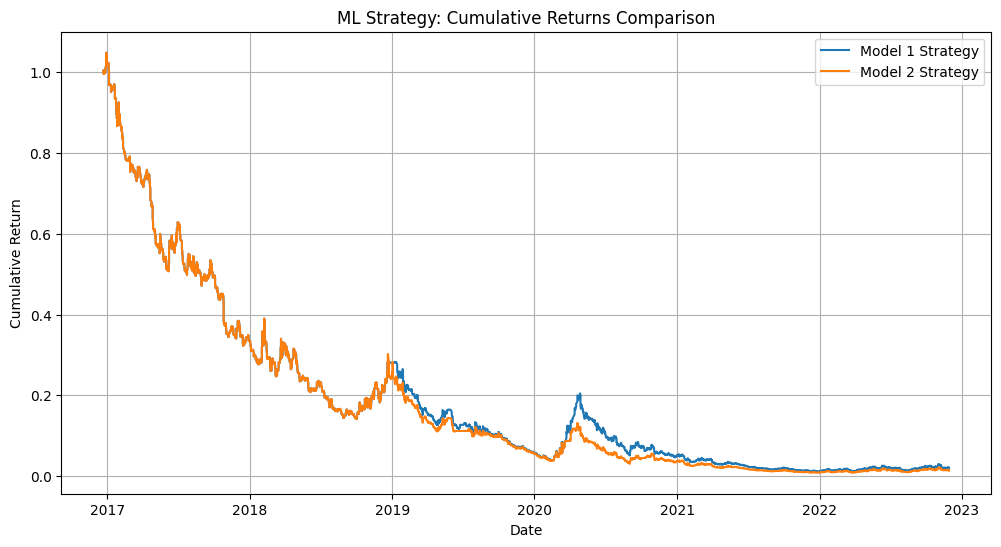

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

def generate_positions(y_prob, threshold_high=0.55, threshold_low=0.45, index=None):
    signals = pd.Series(y_prob[:, 1], index=index)
    positions = signals.apply(lambda x: 1 if x > threshold_high else (-1 if x < threshold_low else 0))
    return positions

def compute_strategy_returns(positions, features, tickers):
    returns = []
    for ticker in tickers:
        df_stock = features[features['ticker'] == ticker].copy()
        ret = df_stock['Close'].pct_change().shift(-1)
        returns.append(ret)
    returns = pd.concat(returns).loc[positions.index]
    strategy_returns = positions * returns
    cumulative_returns = (1 + strategy_returns.fillna(0)).cumprod()
    return cumulative_returns

# --- Model 1 ---
y_prob_model = model.predict_proba(X_test_selected)
positions_model = generate_positions(y_prob_model, index=y_test_clean.index)
cumulative_returns_model1 = compute_strategy_returns(positions_model, features, tickers)

# --- Model 2 ---
y_prob_model2 = model2.predict_proba(X_test_selected)
positions_model2 = generate_positions(y_prob_model2, index=y_test_clean.index)
cumulative_returns_model2 = compute_strategy_returns(positions_model2, features, tickers)

# --- Plot both cumulative returns ---
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns_model1, label='Model 1 Strategy')
plt.plot(cumulative_returns_model2, label='Model 2 Strategy')
plt.title('ML Strategy: Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.show()


In [137]:
def evaluate_model(model_name, model, X_test, y_test, y_pred, y_prob, feature_names):
    from sklearn.metrics import (
        confusion_matrix, classification_report, accuracy_score, roc_auc_score,
        roc_curve, RocCurveDisplay
    )
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd

    not_nan_mask = y_test.notna()
    y_test_cleaned = y_test[not_nan_mask]
    y_pred_cleaned = y_pred[not_nan_mask]
    y_prob_cleaned = y_prob[not_nan_mask]

    print(f"\n================== {model_name} Evaluation ==================")

    # Confusion Matrix
    cm = confusion_matrix(y_test_cleaned, y_pred_cleaned)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Accuracy
    acc = accuracy_score(y_test_cleaned, y_pred_cleaned)
    print(f"Accuracy: {acc:.4f}")

    # AUC Score
    auc = roc_auc_score(y_test_cleaned, y_prob_cleaned[:, 1])
    print(f"AUC: {auc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_cleaned, y_pred_cleaned))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test_cleaned, y_prob_cleaned[:, 1])
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title(f"{model_name} - ROC Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Feature Importances (Logistic Regression)
    if hasattr(model, "coef_"):
        feature_importances = np.abs(model.coef_[0])
        importance_series = pd.Series(feature_importances, index=feature_names)
        sorted_importance = importance_series.sort_values(ascending=False)
        top_n = 20
        print(f"\nTop {top_n} Feature Importances ({model_name}):")
        print(sorted_importance.head(top_n))

        plt.figure(figsize=(10, 6))
        sorted_importance.head(top_n).plot(kind="bar")
        plt.title(f"{model_name} - Top {top_n} Feature Importances")
        plt.ylabel("Absolute Coefficient Value")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


In [146]:
evaluate_model(
    model_name="Model 1 (Logistic RegressionCV)",
    model=model,
    X_test=X_test_selected,
    y_test=y_test_clean,
    y_pred=y_pred,
    y_prob=y_prob,
    feature_names=X.columns[selector_tree.get_support() & selector_mi.get_support()] # Use original feature names after selections
)

evaluate_model(
    model_name="Model 2 (Logistic Regression Elasticnet)",
    model=model2,
    X_test=X_test_selected,
    y_test=y_test_clean,
    y_pred=model2.predict(X_test_selected), # Generate predictions for Model 2
    y_prob=model2.predict_proba(X_test_selected), # Generate probabilities for Model 2
    feature_names=X.columns[selector_tree.get_support() & selector_mi.get_support()] # Use original feature names after selections
)

ValueError: operands could not be broadcast together with shapes (100,) (50,) 